## Keep Attention

The dataset in use is now the full dataset, if you want to use the smaller one change the path inside the _spark.read.csv_.

### LIBRARIES

In [1]:
# importing necessary libraries


from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, PolynomialExpansion, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import avg, max, when, median
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
# Creating the spark session

from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.driver.memory", "4g").set("spark.executor.memory", "4g")
spark = SparkSession.builder.config(conf=conf).appName("loan_dataset").getOrCreate()



In [3]:

# Read the dataset into a DataFrame using the specified schema
#df = spark.read.csv("credit_data.csv", header=True, inferSchema=True)

df = spark.read.csv("credit_data_full.csv", header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.toPandas().head()


,Age,Gender,Income,Credit_Score,Credit_History_Length,Number_of_Existing_Loans,Loan_Amount,Loan_Tenure,Existing_Customer,State,City,LTV_Ratio,Employment_Profile,Profile_Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker
3,69,Female,46000,668,349,6,150000,148,Yes,Karnataka,Bengaluru,87.393365,Self-Employed,86,Contractor
4,52,Male,132000,601,553,5,150000,157,No,Karnataka,Mysuru,66.158757,Salaried,90,Teacher


In [4]:
df.describe().toPandas()

,summary,Age,Gender,Income,Credit_Score,Credit_History_Length,Number_of_Existing_Loans,Loan_Amount,Loan_Tenure,Existing_Customer,State,City,LTV_Ratio,Employment_Profile,Profile_Score,Occupation
0,count,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856,279856
1,mean,44.00521696872677,None,76499.16385569722,582.953772654508,307.96514636098567,4.701693013549826,105795.34277271168,133.34065376479333,None,None,None,71.64310107538067,None,77.3501550797553,None
2,stddev,15.3110509208066,None,42875.57519280222,163.07675415692245,175.08326792343792,2.9803507697460496,40458.370929219716,96.06413248745437,None,None,None,16.86578456606675,None,24.50919563949047,None
3,min,18,Female,9000,300,6,0,5294,12,No,Delhi,Ahmedabad,40.0,Freelancer,0,Banker
4,max,70,Other,209000,850,611,10,150000,359,Yes,West Bengal,Udaipur,95.0,Unemployed,100,Writer


### Exploratory Data Analysis

Check the null values

In [5]:
# Handling Null Values with Imputer
numerical_columns = ["Age", "Income", "Credit_Score", "Credit_History_Length", "Number_of_Existing_Loans", "Loan_Amount", "Loan_Tenure", "LTV_Ratio", "Profile_Score"]
imputer = Imputer(inputCols=numerical_columns, outputCols=[f"{col}_imputed" for col in numerical_columns])

Reading Outliers

In [6]:
from pyspark.sql.functions import col

# List of numerical columns
numerical_columns = ["Age", "Income", "Credit_Score", "Credit_History_Length", "Number_of_Existing_Loans", "Loan_Amount", "Loan_Tenure", "LTV_Ratio", "Profile_Score"]

# Define a function to detect outliers using IQR
def detect_outliers(column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers

# Detect outliers in each numerical column
outliers_dict = {column: detect_outliers(column) for column in numerical_columns}

# Display the count of outliers in each numerical column
for column, outliers in outliers_dict.items():
    print(f"{column}: {outliers.count()} outliers")

# # Show some sample rows of outliers in each numerical column
# for column, outliers in outliers_dict.items():
#     print(f"\nOutliers in {column}:")
#     outliers.show(5)


Age: 0 outliers
Income: 4778 outliers
Credit_Score: 0 outliers
Credit_History_Length: 0 outliers
Number_of_Existing_Loans: 0 outliers
Loan_Amount: 0 outliers
Loan_Tenure: 4042 outliers
LTV_Ratio: 0 outliers
Profile_Score: 2740 outliers


Imputing numerical columns with outliers using Median

In [7]:
# Impute "Income" and "Loan_Tenure" with median
if column in ["Income", "Loan_Tenure"]:
    median_value = df.approxQuantile(column, [0.5], 0.05)[0]
    df = df.na.fill(median_value, [column])
else:
    print(f"{column}: Unable to compute outliers (insufficient data)")

# Show the DataFrame after imputation
df.show(5)


Profile_Score: Unable to compute outliers (insufficient data)
+---+------+------+------------+---------------------+------------------------+-----------+-----------+-----------------+-------------+---------+-----------------+------------------+-------------+-----------------+
|Age|Gender|Income|Credit_Score|Credit_History_Length|Number_of_Existing_Loans|Loan_Amount|Loan_Tenure|Existing_Customer|        State|     City|        LTV_Ratio|Employment_Profile|Profile_Score|       Occupation|
+---+------+------+------------+---------------------+------------------------+-----------+-----------+-----------------+-------------+---------+-----------------+------------------+-------------+-----------------+
| 31|  Male| 36000|         604|                  487|                       5|     109373|        221|               No|    Karnataka|   Mysuru|90.94342996168837|          Salaried|           77|           Doctor|
| 25|  Male| 50000|         447|                  386|                       2

Now, lets check categorical columns for null values

In [8]:
# from pyspark.sql.functions import col

# # List of categorical columns
# categorical_columns = ["Gender", "Existing_Customer", "State", "City", "Employment_Profile", "Occupation"]

# # Display null values in categorical columns
# print("Null values in categorical columns:")
# for column in categorical_columns:
#     null_count = df.where(col(column).isNull()).count()
#     print(f"{column}: {null_count} null values")


As we observed some "NA" values in the occupation column from csv file, lets read the occupation column.

In [9]:

# Display unique values in the "Occupation" column along with their counts
occupation_counts = df.groupBy("Occupation").count().orderBy("count", ascending=False)
occupation_counts.show()


+--------------------+-----+
|          Occupation|count|
+--------------------+-----+
|              Banker|27760|
|             Teacher|27356|
|       Civil Servant|27221|
|   Software Engineer|27146|
|              Doctor|26582|
|          Shopkeeper|21405|
|          Contractor|21090|
|              Farmer|20966|
|      Business Owner|20908|
|             Student|18521|
|                  NA|18272|
|    Graphic Designer| 5723|
|        Photographer| 5706|
|Independent Consu...| 5628|
|              Writer| 5572|
+--------------------+-----+



Found 1677 Rows with NA values

In [10]:
from pyspark.sql.functions import expr

# Replace "NA" with None in the "Occupation" column
df = df.withColumn("Occupation", when(col("Occupation") == "NA", None).otherwise(col("Occupation")))

# Display unique values in the "Occupation" column along with their counts after replacement
occupation_counts_after_replace = df.groupBy("Occupation").count().orderBy("count", ascending=False)

# Display the DataFrame with "None" instead of null
occupation_counts_after_replace.withColumn("Occupation", expr("IFNULL(Occupation, 'None')")).show(truncate=False)



+----------------------+-----+
|Occupation            |count|
+----------------------+-----+
|Banker                |27760|
|Teacher               |27356|
|Civil Servant         |27221|
|Software Engineer     |27146|
|Doctor                |26582|
|Shopkeeper            |21405|
|Contractor            |21090|
|Farmer                |20966|
|Business Owner        |20908|
|Student               |18521|
|None                  |18272|
|Graphic Designer      |5723 |
|Photographer          |5706 |
|Independent Consultant|5628 |
|Writer                |5572 |
+----------------------+-----+



Renamed Rows with NA to None in the Occupation column.

#### Data Visualization

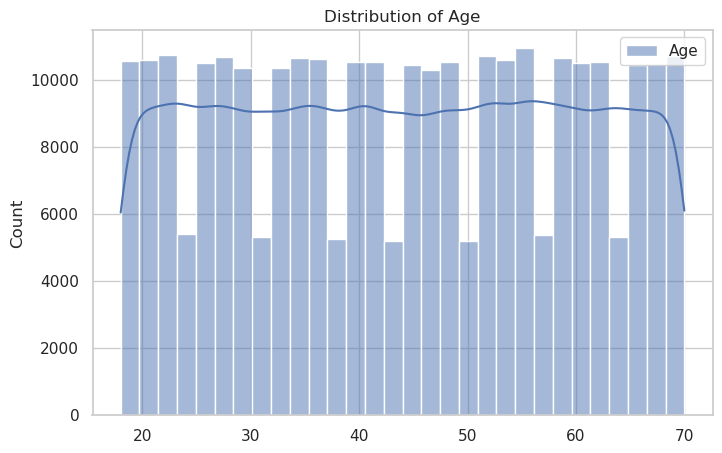

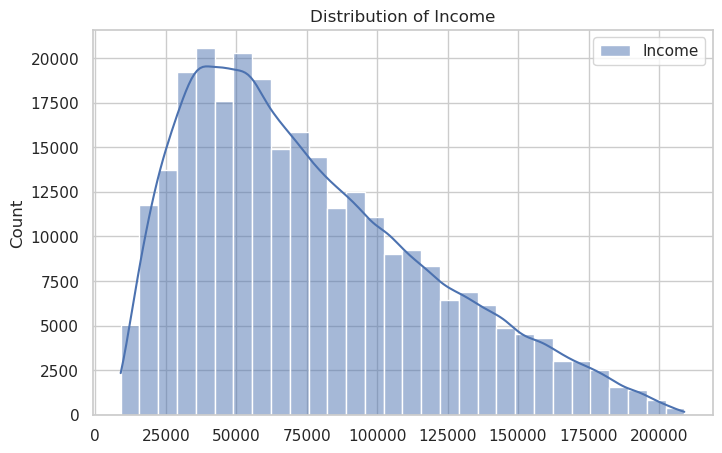

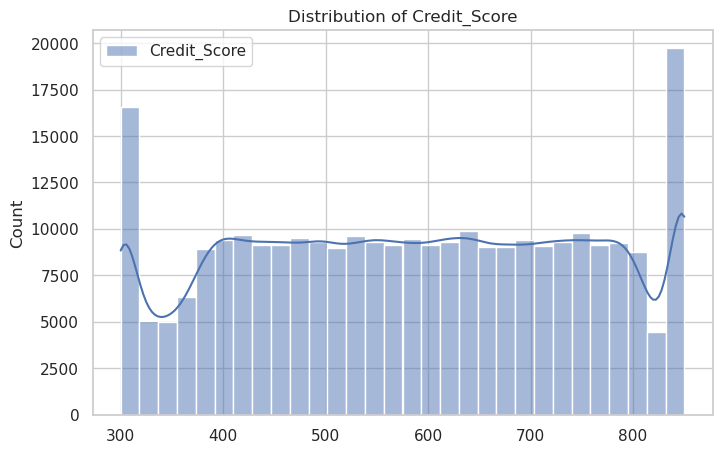

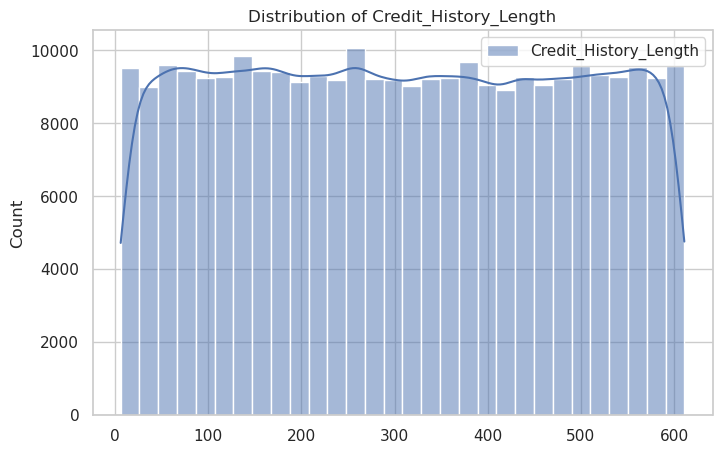

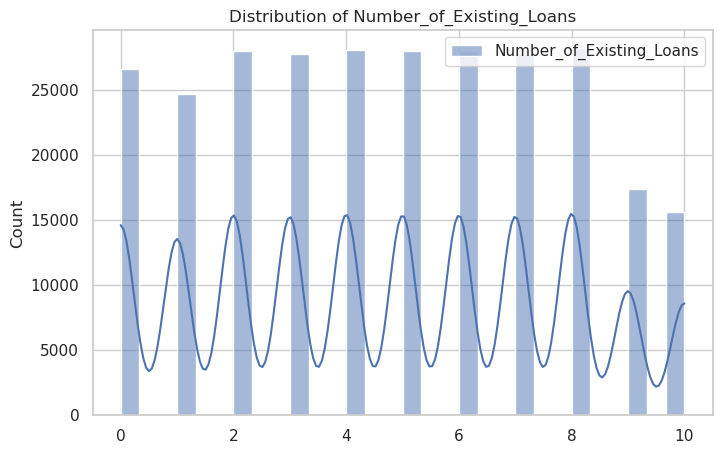

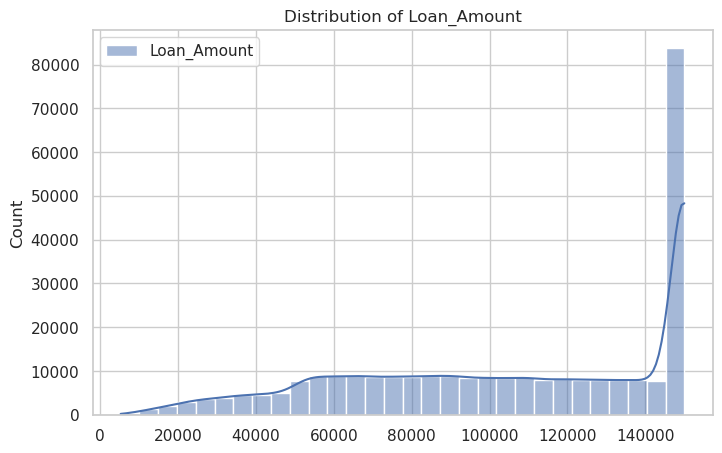

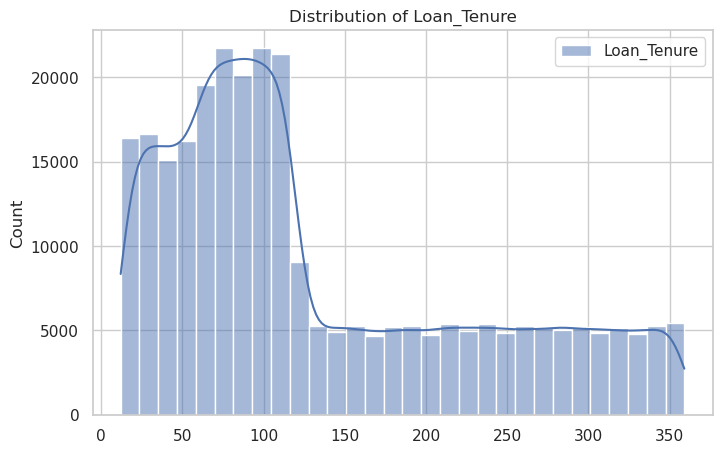

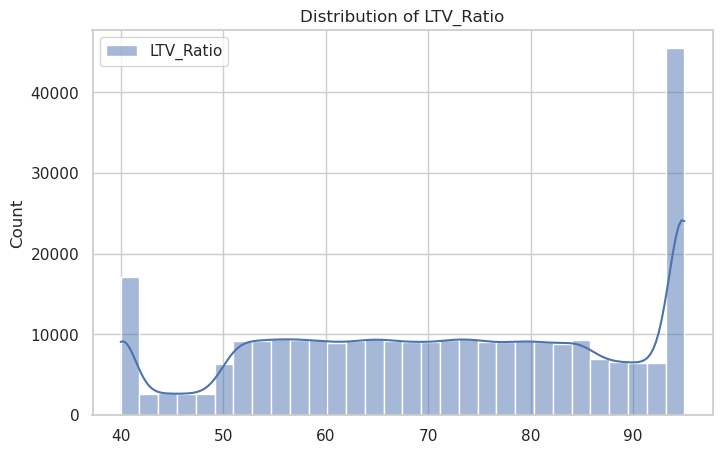

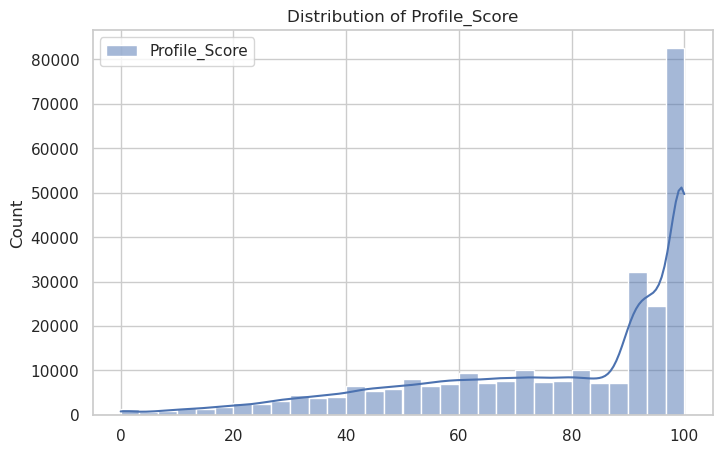

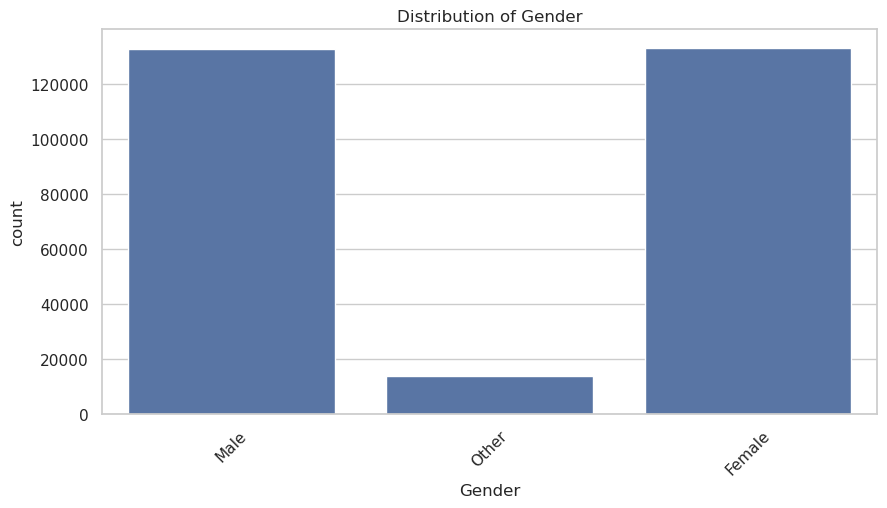

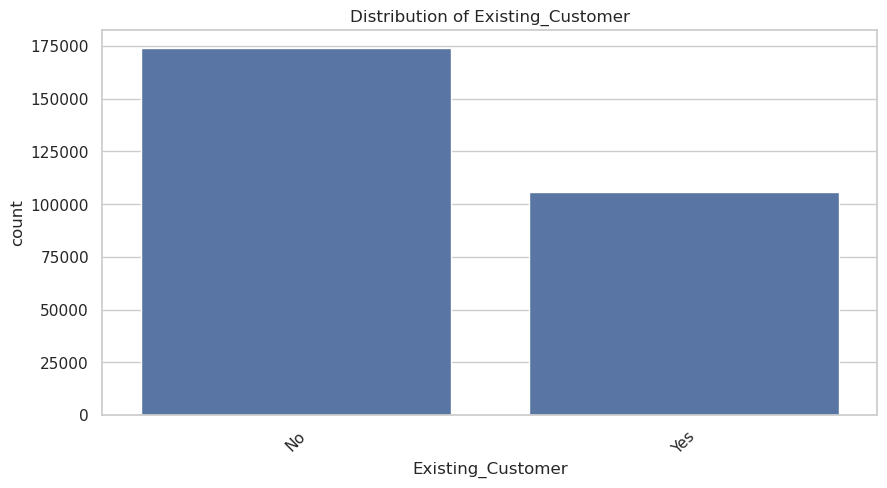

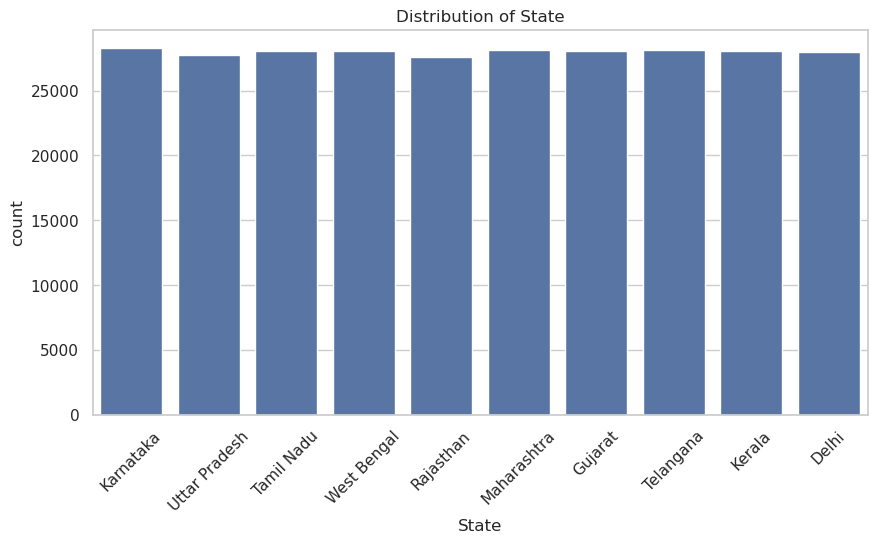

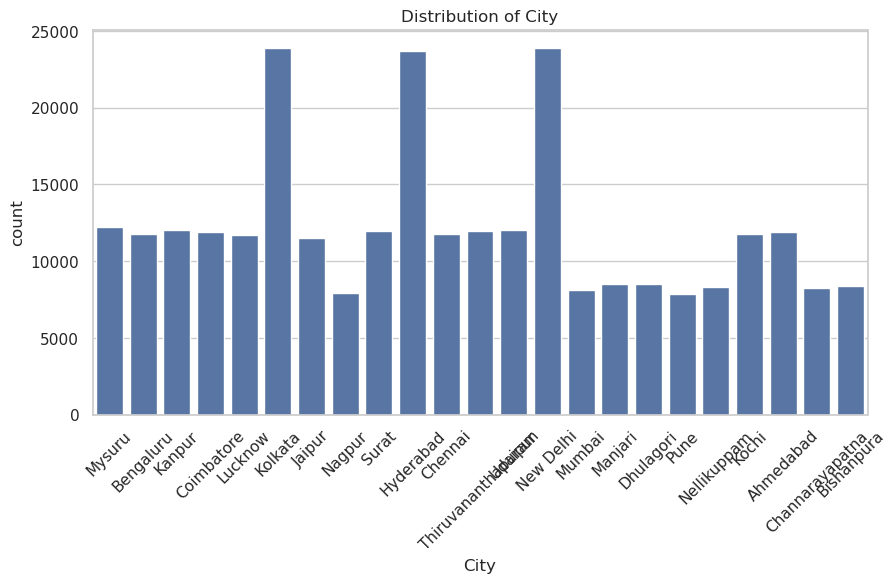

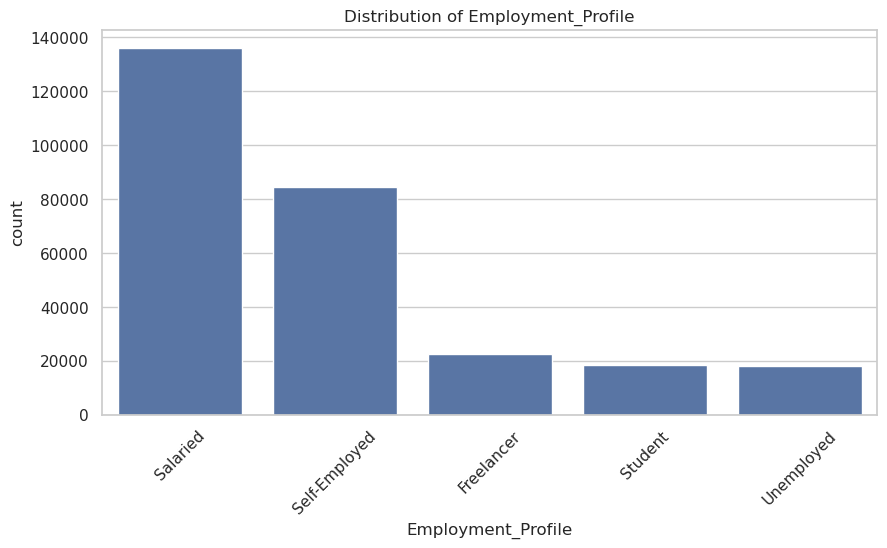

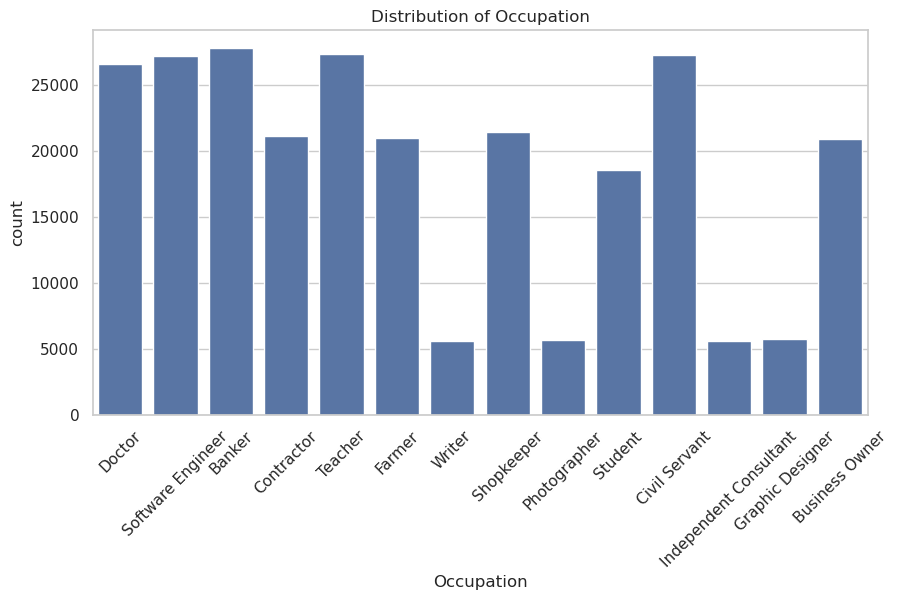

In [11]:
# Set the style for seaborn
sns.set(style="whitegrid")

# List of numerical and categorical columns
numerical_columns = ["Age", "Income", "Credit_Score", "Credit_History_Length", "Number_of_Existing_Loans", "Loan_Amount", "Loan_Tenure", "LTV_Ratio", "Profile_Score"]
categorical_columns = ["Gender", "Existing_Customer", "State", "City", "Employment_Profile", "Occupation"]

# Plot histograms for numerical columns
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df.select(column).toPandas(), bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Plot bar plots for categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df.toPandas(), x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

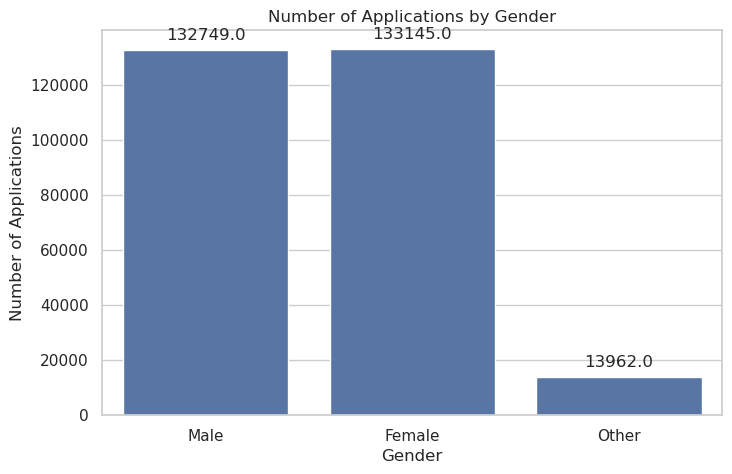

In [12]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for the number of applications by gender
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df.toPandas(), x="Gender", order=["Male", "Female", "Other"])
plt.title("Number of Applications by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Applications")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

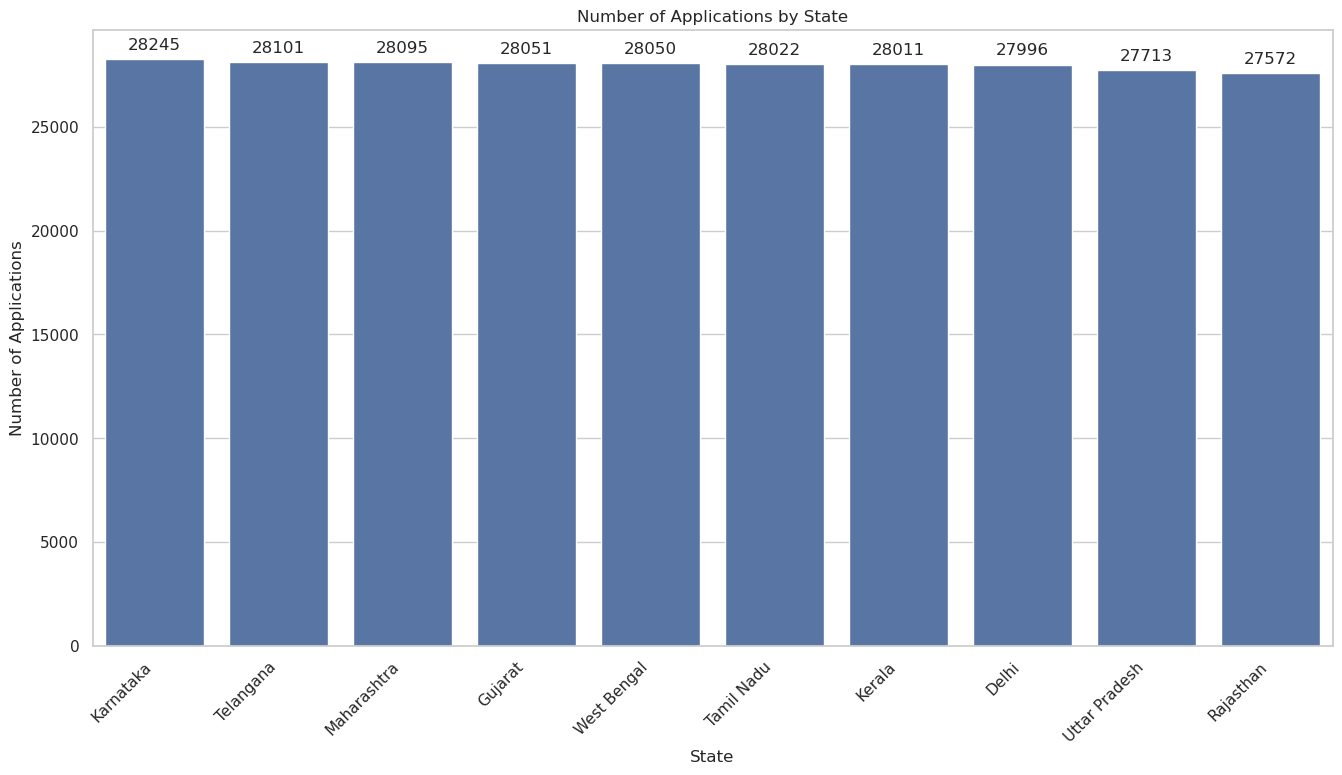

In [13]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Count the number of applications by state
applications_by_state = df.groupBy("State").count().orderBy("count", ascending=False)

# Create a bar plot for the number of applications by state
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=applications_by_state.toPandas(), x="State", y="count")
plt.title("Number of Applications by State")
plt.xlabel("State")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Applications by State:
- Highest from Karnataka
- lowest from Rajasthan

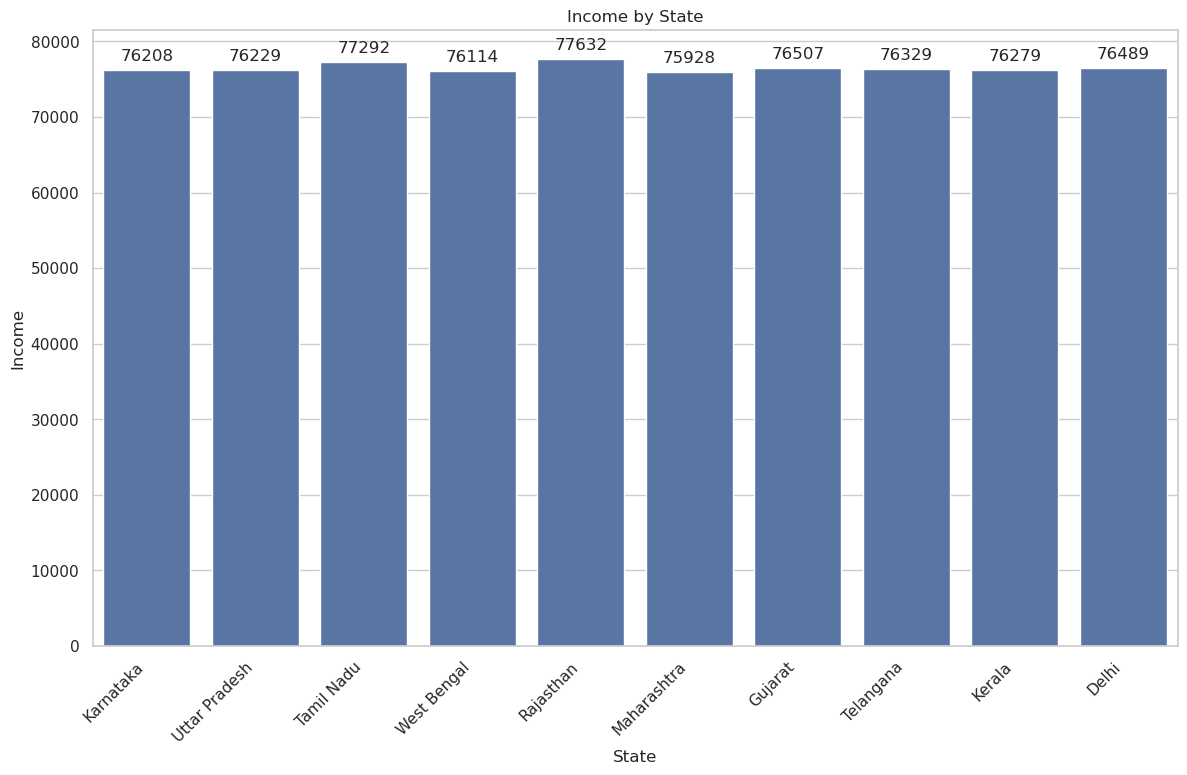

In [14]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for each state
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df.toPandas(), x="State", y="Income", errorbar=None)
plt.title("Income by State")
plt.xlabel("State")
plt.ylabel("Income")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Income by State:
- Highest by Rajasthan
- Lowest by Utta Pradesh

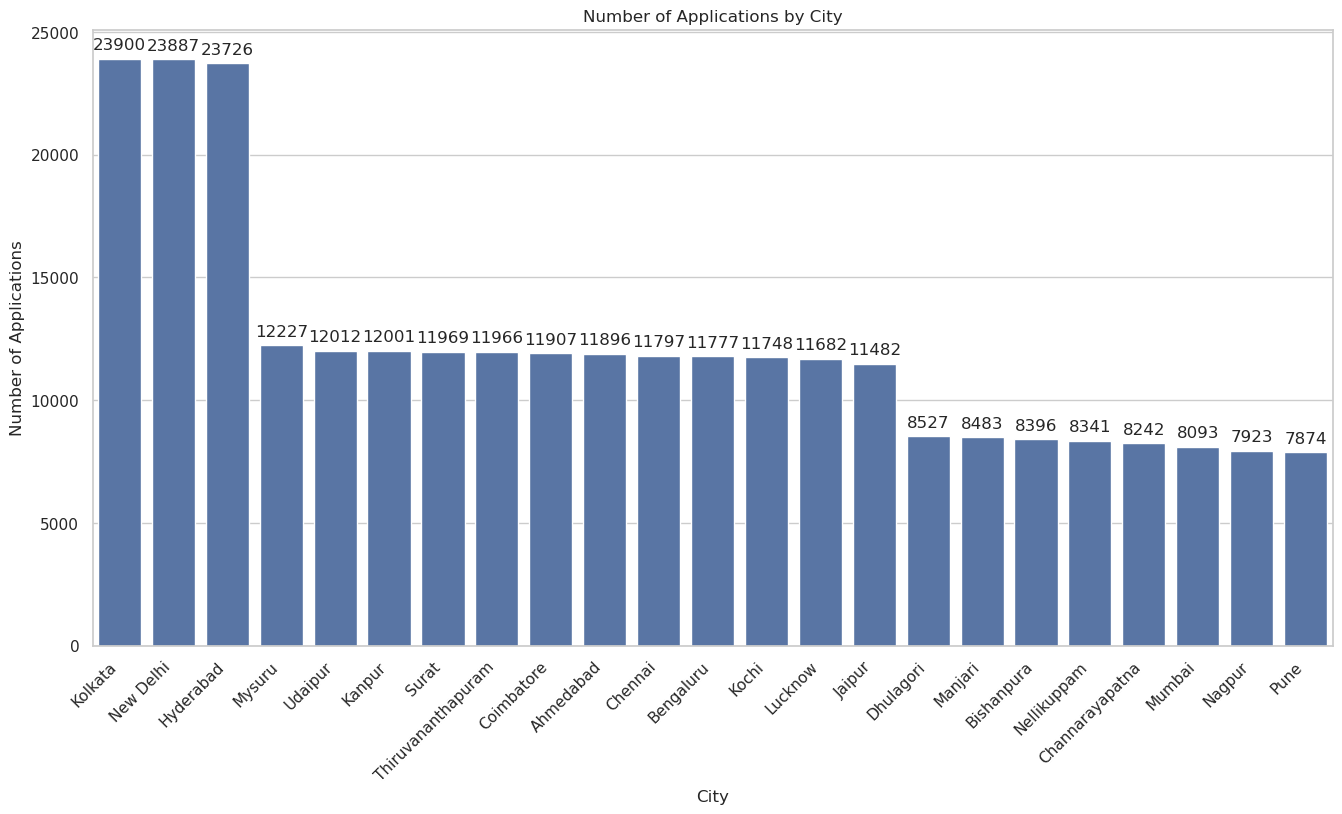

In [15]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Count the number of applications by city
applications_by_city = df.groupBy("City").count().orderBy("count", ascending=False)

# Create a bar plot for the number of applications by city
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=applications_by_city.toPandas(), x="City", y="count")
plt.title("Number of Applications by City")
plt.xlabel("City")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Applications by City
- Highest by Hyderabad
- Lowest by Pune

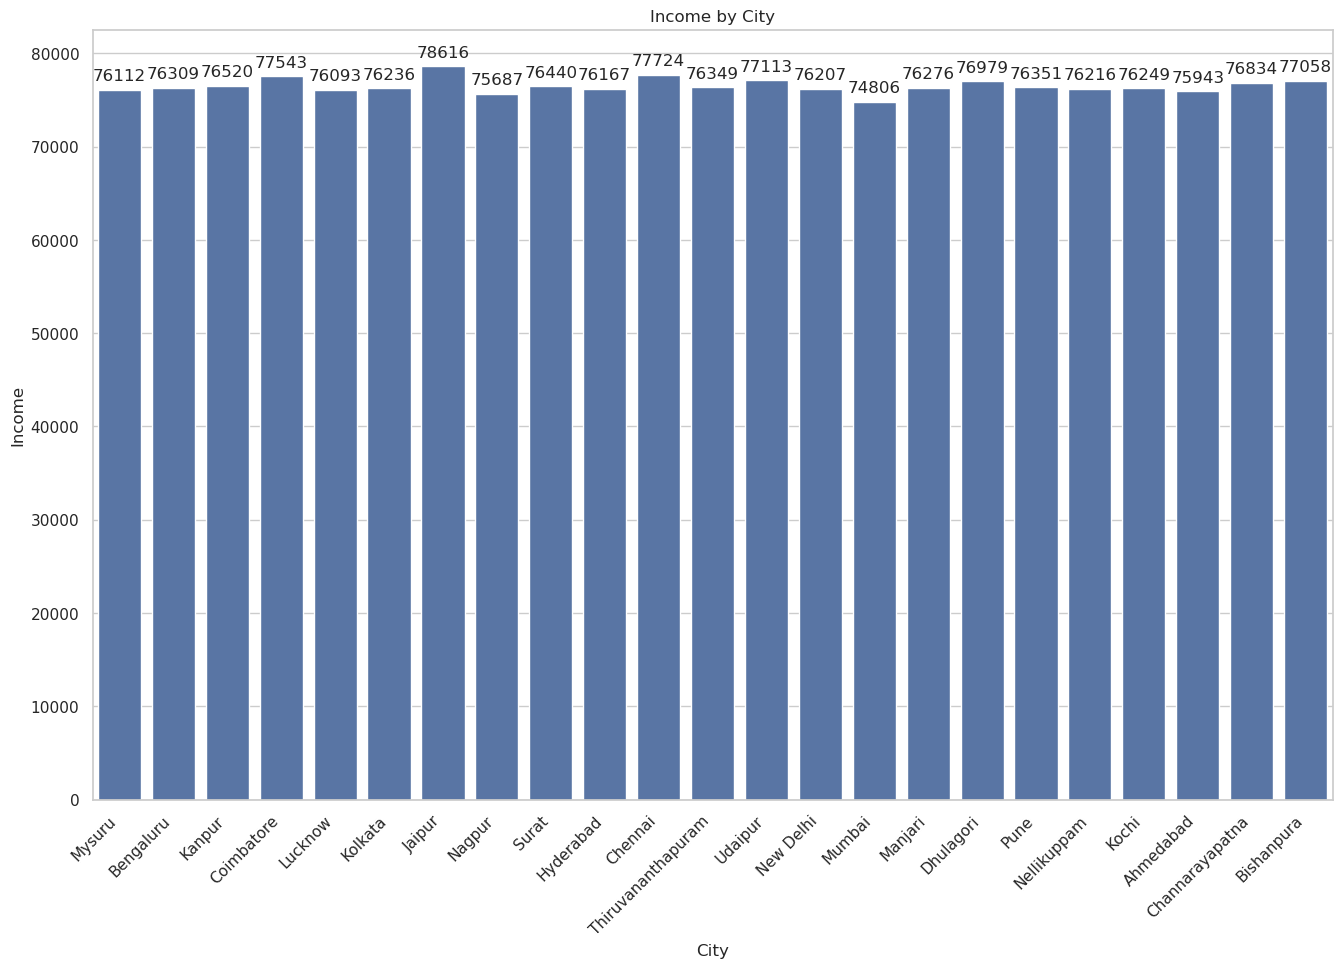

In [16]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for income by city
plt.figure(figsize=(16, 10))
ax = sns.barplot(data=df.toPandas(), x="City", y="Income", errorbar=None)
plt.title("Income by City")
plt.xlabel("City")
plt.ylabel("Income")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Income by City
- Highest by Jaipur
- Lowest by Mumbai

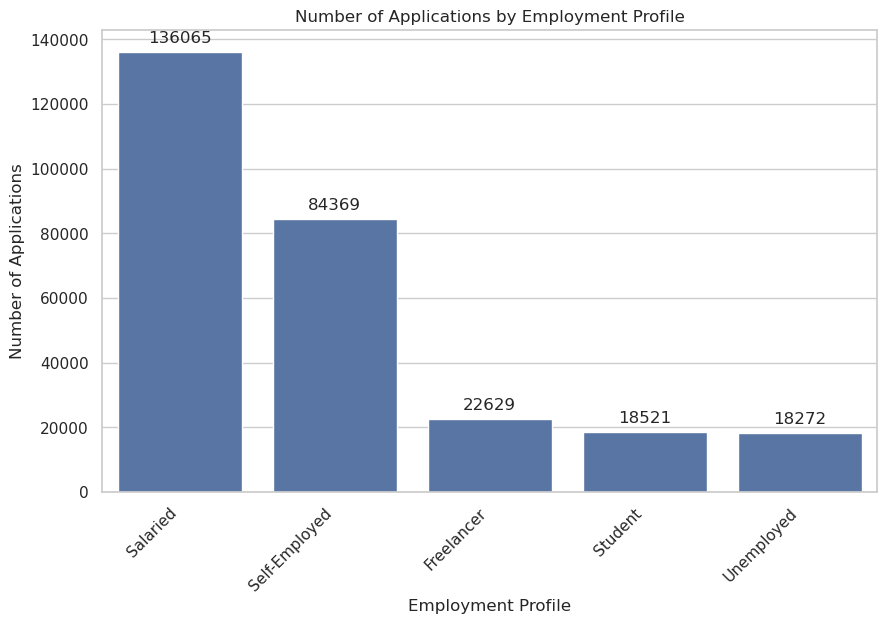

In [17]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Count the number of applications by Employment Profile
applications_by_employment_profile = df.groupBy("Employment_Profile").count().orderBy("count", ascending=False)

# Create a bar plot for the number of applications by Employment Profile
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=applications_by_employment_profile.toPandas(), x="Employment_Profile", y="count")
plt.title("Number of Applications by Employment Profile")
plt.xlabel("Employment Profile")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Application by Employment Profile:
- Highest by Salaried
- lowest by Unemployed

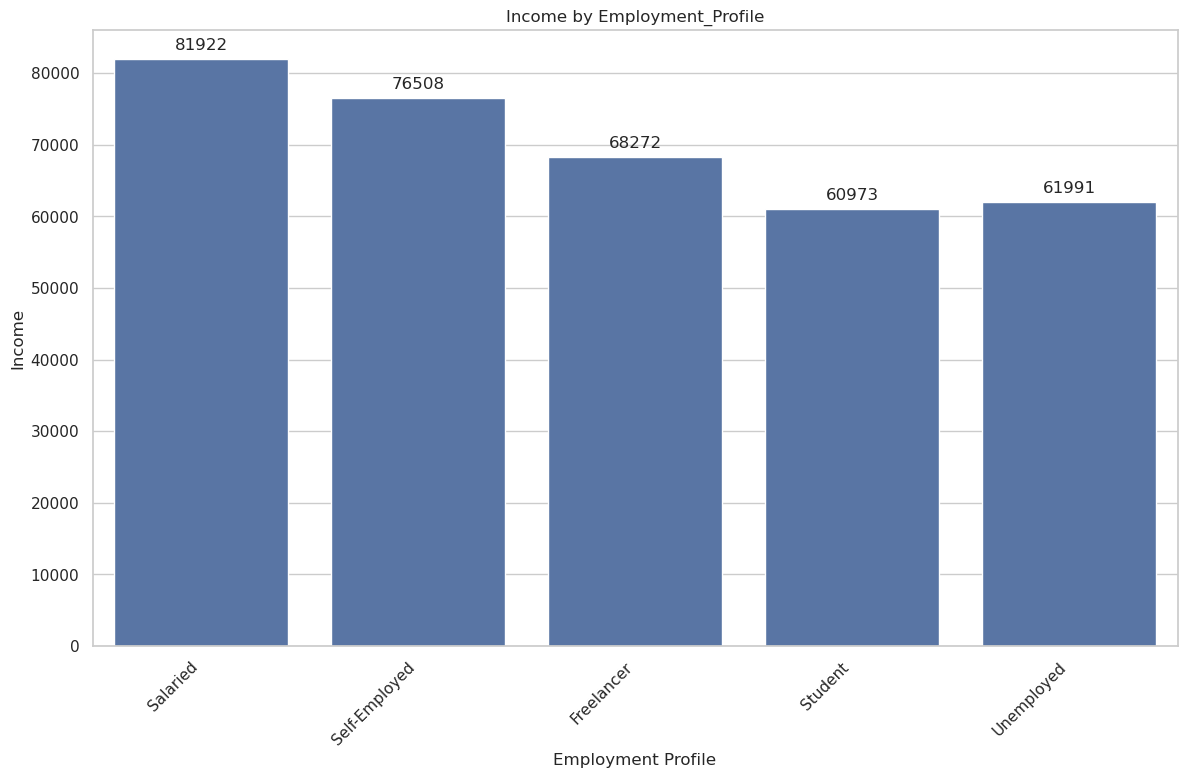

In [18]:

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for income by employment profile
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df.toPandas(), x="Employment_Profile", y="Income", errorbar=None)
plt.title("Income by Employment_Profile")
plt.xlabel("Employment Profile")
plt.ylabel("Income")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Income by Empolyment Profile:
- Highest by Salaried
- Lowest by Student(obvious)
- Interesting point, Salaried Persons have highest Income than Self-Employed.

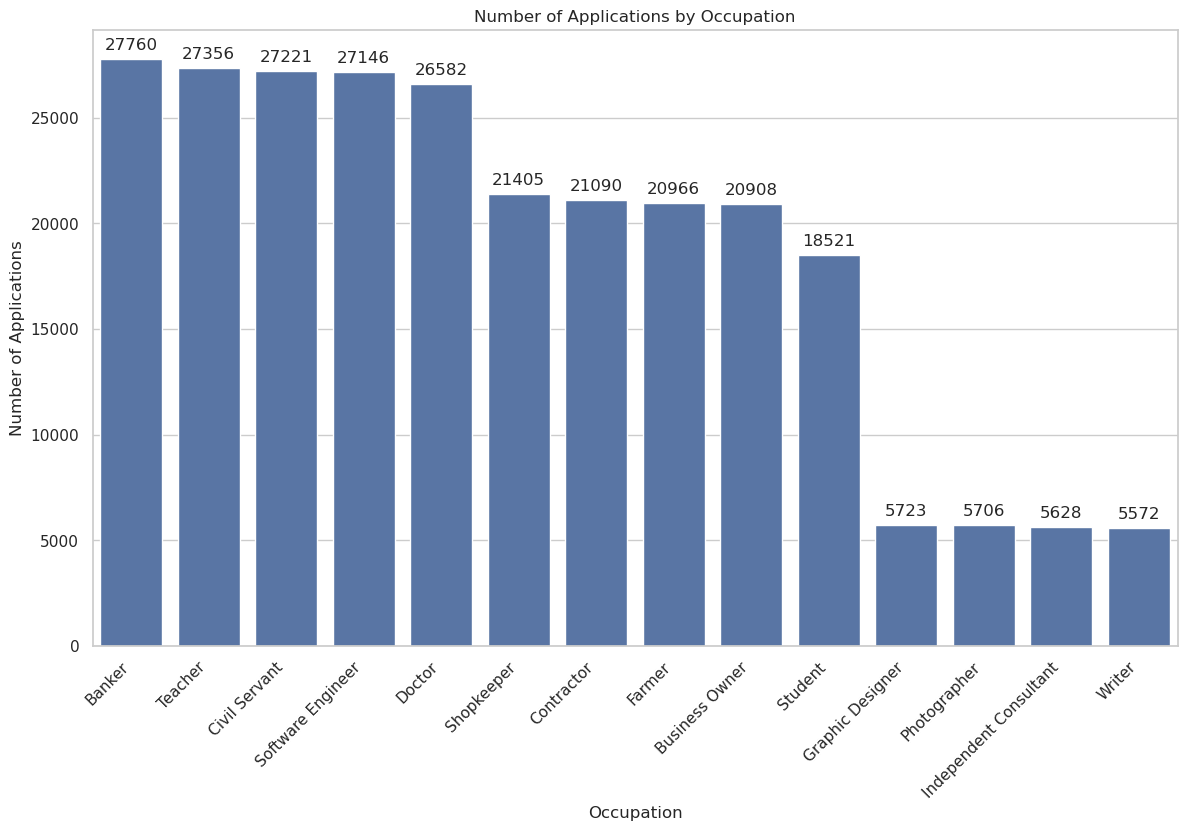

In [19]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Count the number of applications by Occupation
applications_by_occupation = df.groupBy("Occupation").count().orderBy("count", ascending=False)

# Create a bar plot for the number of applications by Occupation
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=applications_by_occupation.toPandas(), x="Occupation", y="count")
plt.title("Number of Applications by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Applications by Occupation
- Highest by Banker
- Lowest by Writer

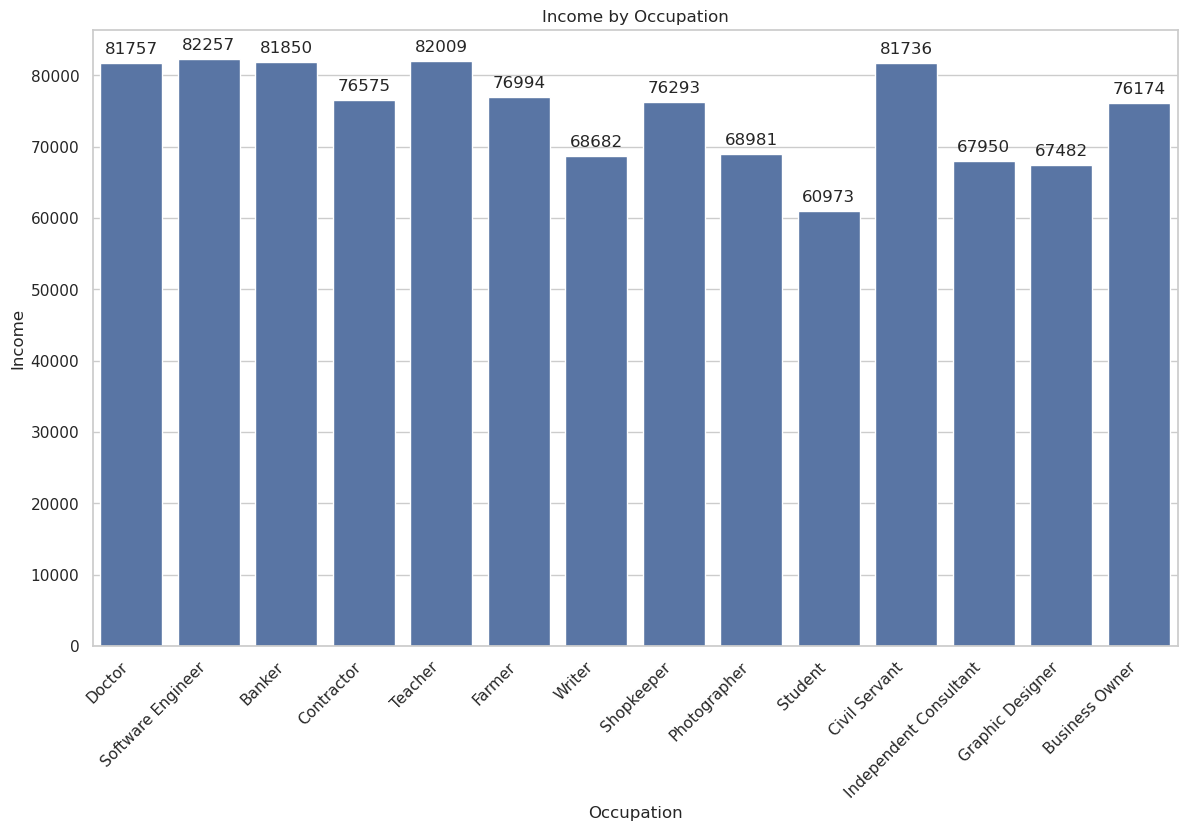

In [20]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for income by occupation
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df.toPandas(), x="Occupation", y="Income", errorbar=None)
plt.title("Income by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Income")
plt.xticks(rotation=45, ha="right")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Income by Occupation
- Highest by Software Engineer
- Lowest by Student (obvious)

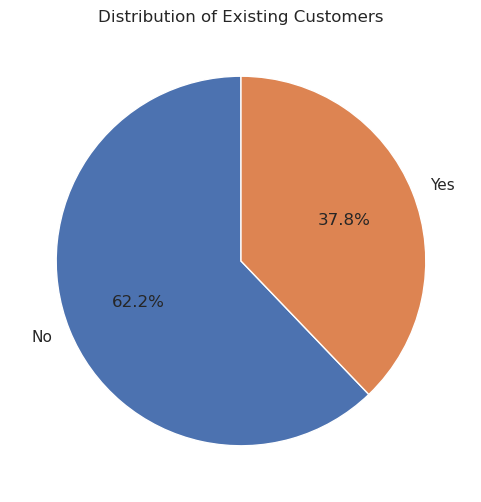

In [21]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a pie chart for the distribution of existing customers
existing_customer_counts = df.groupBy("Existing_Customer").count().toPandas()

plt.figure(figsize=(6, 6))
plt.pie(existing_customer_counts["count"], labels=existing_customer_counts["Existing_Customer"], autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Existing Customers")
plt.show()

Among the number of applications received, approximately two-third of them are new customers.

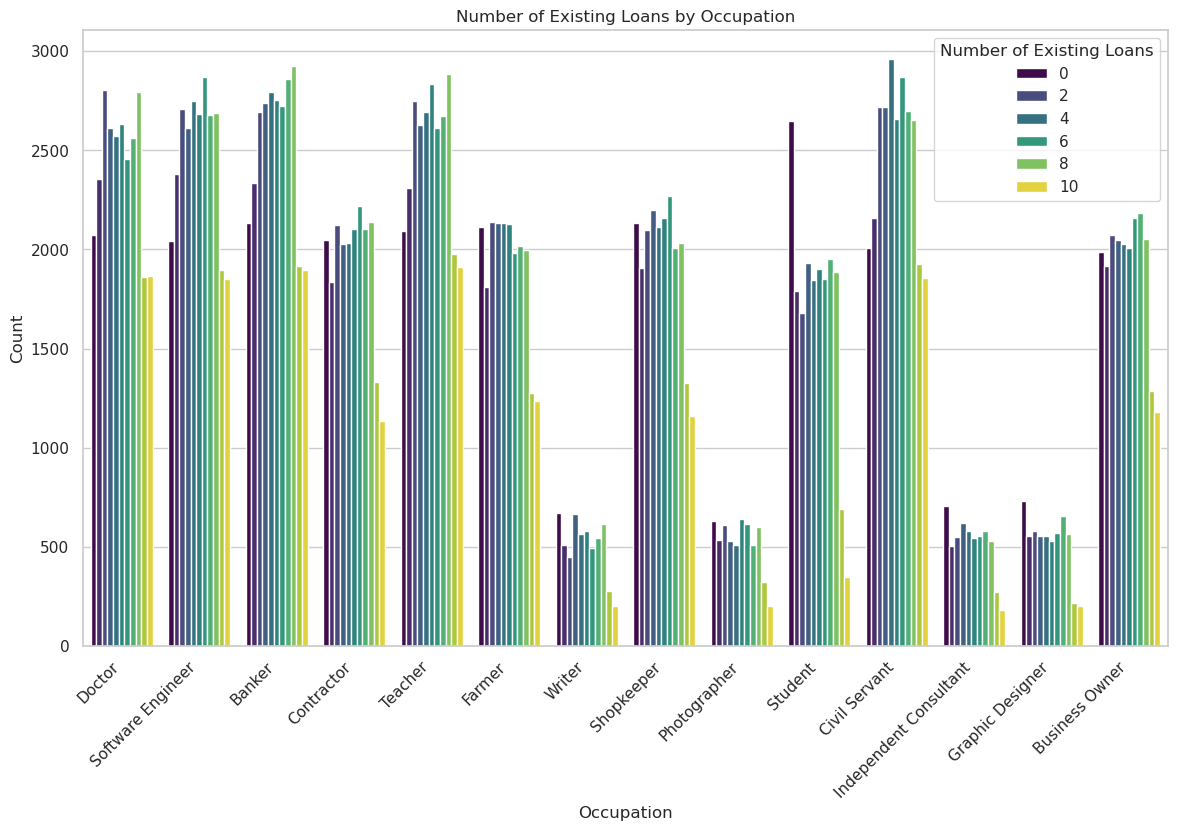

In [22]:

# Set the style for seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.countplot(data=df.toPandas(), x="Occupation", hue="Number_of_Existing_Loans", palette="viridis")
plt.title("Number of Existing Loans by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Number of Existing Loans")
plt.show()

- Students category have most zero existing loans.
- Occupation with Doctor, Software Engineer, Banker and Teacher categories have high number of existing loans with number 10

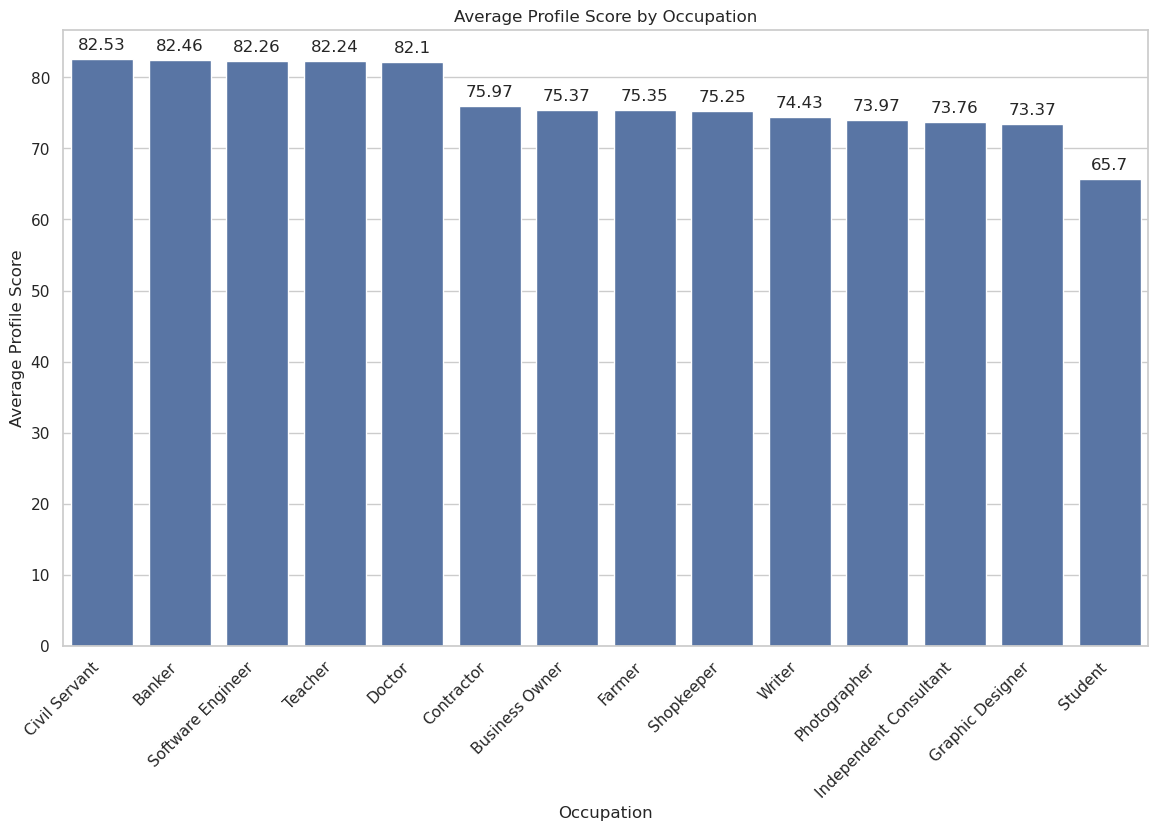

In [23]:
from pyspark.sql.functions import avg

# Group by Occupation and calculate the average Profile_Score
average_profile_score_by_occupation = df.groupBy("Occupation").agg(avg("Profile_Score").alias("Average_Profile_Score")).orderBy("Average_Profile_Score", ascending=False)

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a bar plot for Average Profile Score by Occupation
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=average_profile_score_by_occupation.toPandas(), x="Occupation", y="Average_Profile_Score", errorbar=None)
plt.title("Average Profile Score by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average Profile Score")

# Add exact numbers as labels on the bars
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(), 2)}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha="right")
plt.show()


From the above plot, 
we observed that Civil Servant, Banker & Software Engineer have the good Profile score.

In [24]:
df.toPandas().head()

,Age,Gender,Income,Credit_Score,Credit_History_Length,Number_of_Existing_Loans,Loan_Amount,Loan_Tenure,Existing_Customer,State,City,LTV_Ratio,Employment_Profile,Profile_Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker
3,69,Female,46000,668,349,6,150000,148,Yes,Karnataka,Bengaluru,87.393365,Self-Employed,86,Contractor
4,52,Male,132000,601,553,5,150000,157,No,Karnataka,Mysuru,66.158757,Salaried,90,Teacher


In [25]:

# # Encoding Categorical Features
# categorical_columns = ["Gender", "Existing_Customer", "State", "City", "Employment_Profile", "Occupation"]

# indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_columns]
# encoder = OneHotEncoder(inputCols=[f"{col}_index" for col in categorical_columns], outputCols=[f"{col}_encoded" for col in categorical_columns])

# # Creating Interaction Terms
# interaction_assembler = VectorAssembler(inputCols=["Income", "Credit_History_Length"], outputCol="interaction_features")

# # Assemble features for modeling
# feature_columns = ["Income", "Credit_History_Length"] + [f"{col}_encoded" for col in categorical_columns] + ["interaction_features"]
# feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# # Pipeline
# pipeline = Pipeline(stages=indexers + [encoder, interaction_assembler, feature_assembler])
# model_pipeline = pipeline.fit(df)
# df_transformed = model_pipeline.transform(df)



#### FEATURE ENGINEERING II

In [26]:
# Feature Engineering and Encoding Categorical Features
categorical_columns = ["Gender", "Existing_Customer", "State", "City", "Employment_Profile", "Occupation"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_columns]
encoder = OneHotEncoder(inputCols=[f"{col}_index" for col in categorical_columns], outputCols=[f"{col}_encoded" for col in categorical_columns])

In [27]:
# Assembling Features
assembler = VectorAssembler(inputCols=[f"{col}_imputed" for col in numerical_columns] + [f"{col}_encoded" for col in categorical_columns], outputCol="features")

#### Model Development & Evaluation

- RandomForest Regressor

In [28]:

rf = RandomForestRegressor(labelCol="Credit_Score", featuresCol="features", numTrees=10, maxDepth=5, seed=42)

from pyspark.ml.feature import Imputer

# Assuming numerical_columns is a list of numerical column names
imputer = Imputer(inputCols=numerical_columns, outputCols=[f"{col}_imputed" for col in numerical_columns])


# Pipeline
pipeline = Pipeline(stages=[imputer] + indexers + [encoder, assembler, rf])

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Smaller Grid Search for Hyperparameter Tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Cross-Validation
evaluator = RegressionEvaluator(labelCol="Credit_Score", metricName="rmse")
cross_validator = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# Fit the Model
model = cross_validator.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
mae = RegressionEvaluator(labelCol="Credit_Score", metricName="mae").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="Credit_Score", metricName="r2").evaluate(predictions)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Root Mean Squared Error (RMSE): 5.385329749996393
Mean Absolute Error (MAE): 4.321213074211613
R-squared (R2): 0.9989048020527401


- Gradient-Boost Tree Regressor

In [29]:
from pyspark.ml.regression import GBTRegressor

# GBT Regressor Model
gbt = GBTRegressor(labelCol="Credit_Score", featuresCol="features", maxDepth=5, maxIter=20, seed=42)

# Pipeline
pipeline_gbt = Pipeline(stages=[imputer] + indexers + [encoder, assembler, gbt])

# Smaller Grid Search for Hyperparameter Tuning
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Cross-Validation
evaluator_gbt = RegressionEvaluator(labelCol="Credit_Score", metricName="rmse")
cross_validator_gbt = CrossValidator(estimator=pipeline_gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator_gbt, numFolds=3)

# Fit the Model
model_gbt = cross_validator_gbt.fit(train_data)

# Make Predictions
predictions_gbt = model_gbt.transform(test_data)

# Evaluate the model
rmse_gbt = evaluator_gbt.evaluate(predictions_gbt)
mae_gbt = RegressionEvaluator(labelCol="Credit_Score", metricName="mae").evaluate(predictions_gbt)
r2_gbt = RegressionEvaluator(labelCol="Credit_Score", metricName="r2").evaluate(predictions_gbt)

# Print evaluation metrics
print(f"GBT Regressor - Root Mean Squared Error (RMSE): {rmse_gbt}")
print(f"GBT Regressor - Mean Absolute Error (MAE): {mae_gbt}")
print(f"GBT Regressor - R-squared (R2): {r2_gbt}")


GBT Regressor - Root Mean Squared Error (RMSE): 4.453096132502256
GBT Regressor - Mean Absolute Error (MAE): 3.486725793795596
GBT Regressor - R-squared (R2): 0.99925115460941


- Linear Regression Model

In [30]:

# Linear Regression Model
linear_reg = LinearRegression(labelCol="Credit_Score", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Pipeline
pipeline_linear_reg = Pipeline(stages=[imputer] + indexers + [encoder, assembler, linear_reg])

# Smaller Grid Search for Hyperparameter Tuning
param_grid_linear_reg = ParamGridBuilder() \
    .addGrid(linear_reg.regParam, [0.1, 0.3]) \
    .addGrid(linear_reg.elasticNetParam, [0.6, 0.8]) \
    .build()

# Cross-Validation
evaluator_linear_reg = RegressionEvaluator(labelCol="Credit_Score", metricName="rmse")
cross_validator_linear_reg = CrossValidator(estimator=pipeline_linear_reg, estimatorParamMaps=param_grid_linear_reg, evaluator=evaluator_linear_reg, numFolds=3)

# Fit the Model
model_linear_reg = cross_validator_linear_reg.fit(train_data)

# Make Predictions
predictions_linear_reg = model_linear_reg.transform(test_data)

# Evaluate the model
rmse_linear_reg = evaluator_linear_reg.evaluate(predictions_linear_reg)
mae_linear_reg = RegressionEvaluator(labelCol="Credit_Score", metricName="mae").evaluate(predictions_linear_reg)
r2_linear_reg = RegressionEvaluator(labelCol="Credit_Score", metricName="r2").evaluate(predictions_linear_reg)

# Print evaluation metrics
print(f"Linear Regression - Root Mean Squared Error (RMSE): {rmse_linear_reg}")
print(f"Linear Regression - Mean Absolute Error (MAE): {mae_linear_reg}")
print(f"Linear Regression - R-squared (R2): {r2_linear_reg}")


Linear Regression - Root Mean Squared Error (RMSE): 8.09825908696158
Linear Regression - Mean Absolute Error (MAE): 6.91107510535184
Linear Regression - R-squared (R2): 0.9975234257473898


##### Prediction-Test:

In [31]:
new_data = spark.createDataFrame([
    (31, "Male", 36000, 604, 487, 5, 109373, 221, "No", "Karnataka",	"Mysuru", 90.9434299616884, "Salaried", 77, "Doctor"),
    (68, "Female", 68000, 354, 83, 0, 40661, 63, "No", "Uttar Pradesh",	"Kanpur", 70.8546099202296, "Salaried", 74, "Software Engineer")
],
                                 ["Age",  "Gender", "Income", "Credit_Score", "Credit_History_Length", "Number_of_Existing_Loans", "Loan_Amount", "Loan_Tenure", "Existing_Customer", "State", "City", "LTV_Ratio", "Employment_Profile", "Profile_Score", "Occupation"])

In [32]:
# Assuming you have a DataFrame named 'new_data' containing the data for prediction
rf_predictions = model.transform(new_data)

# Display the predictions
rf_predictions.select("Credit_Score", "prediction").show()


+------------+-----------------+
|Credit_Score|       prediction|
+------------+-----------------+
|         604|611.3696089720588|
|         354|340.0851441652016|
+------------+-----------------+



In [33]:
# Assuming you have a DataFrame named 'new_data' containing the data for prediction
gbt_predictions = model_gbt.transform(new_data)

# Display the predictions
gbt_predictions.select("Credit_Score", "prediction").show()


+------------+------------------+
|Credit_Score|        prediction|
+------------+------------------+
|         604| 611.4198157072932|
|         354|349.11645293998936|
+------------+------------------+



In [34]:
# Assuming you have a DataFrame named 'new_data' containing the data for prediction
linear_reg_predictions = model_linear_reg.transform(new_data)

# Display the predictions
linear_reg_predictions.select("Credit_Score", "prediction").show()


+------------+------------------+
|Credit_Score|        prediction|
+------------+------------------+
|         604| 598.3970499402291|
|         354|340.16459865649256|
+------------+------------------+



#### Conclusion:

- From the above three models, we observed that Gradient_Boost Regressor is the best model for Prediction of Credit Score compared to the other two models.